In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import torch
import torch.nn as nn

In [206]:
X = torch.randn(32, 16, 224, 224)

In [252]:
def perceive(X, padding='circular'):
    eye_kernel = torch.tensor([[0.,  0.,  0.], [0.,  1.,  0.], [0.,  0.,  0.]])
    dx = torch.tensor([[-1.,  0.,  1.], [-2.,  0.,  2.], [-1.,  0.,  1.]])/8.
    w = torch.stack([eye_kernel, dx, dx.T])
    w = repeat(w, 'K H W -> (16 K) 1 H W')
    X = nn.functional.pad(X, (1, 1, 1, 1), mode='circular')
    y = nn.functional.conv2d(X, w, padding='valid', groups=16)
    return y
    

In [253]:
y = perceive(X)

torch.Size([32, 16, 226, 226]) torch.Size([48, 1, 3, 3])
torch.Size([32, 48, 224, 224])


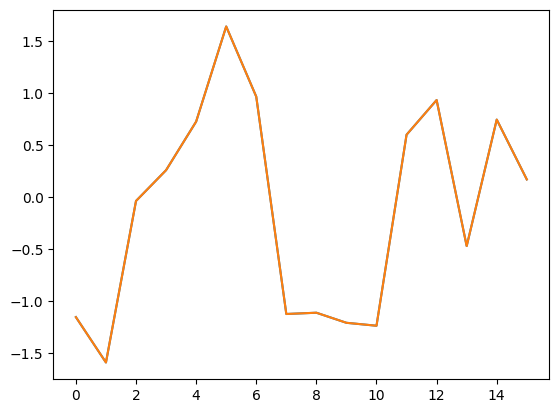

In [254]:
plt.plot(X[0, :, 0, 0]);
plt.plot(y[0, ::3, 0, 0]);

In [240]:
X.shape

torch.Size([32, 16, 224, 224])

torch.Size([32, 16, 226, 226])

In [153]:
nn.Conv2d(16, 48, 3, groups=16).weight.shape

torch.Size([48, 1, 3, 3])

In [305]:
class CellNorm(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x): # B, D, H, W
        return (x - x.mean(dim=-3, keepdim=True))/(x.std(dim=-3, keepdim=True) + 1e-8)  # layernorm over dim=-3

def cell_dropout(x, p_drop=0.5):
    B, D, H, W = x.shape
    keep_mask = torch.rand(B, 1, H, W, dtype=x.dtype, device=x.device) < (1.-p_drop)
    return x * keep_mask.to(x.dtype)

class NCAPerceive(nn.Module):
    def __init__(self, padding_mode='circular'):
        super().__init__()
        self.padding_mode = padding_mode
    def forward(self, x):
        eye_kernel = torch.tensor([[0.,  0.,  0.], [0.,  1.,  0.], [0.,  0.,  0.]])
        dx = torch.tensor([[-1.,  0.,  1.], [-2.,  0.,  2.], [-1.,  0.,  1.]])/8.
        w = torch.stack([eye_kernel, dx, dx.T])
        w = repeat(w, 'K H W -> (16 K) 1 H W')
        x = nn.functional.pad(x, (1, 1, 1, 1), mode=self.padding_mode)
        x = nn.functional.conv2d(x, w, padding='valid', groups=16)
        return x
        
class NCA(nn.Module):
    def __init__(self, d_state=16, # input vars
                 kernel_size=-1, padding_mode='zeros', # perceive vars
                 d_embds=[48, 128], cell_norm=False, # network vars
                 state_unit_norm=False, dt=0.01, dropout=0.5): # dynamics vars
        super().__init__()
        if kernel_size == -1:
            perceive = NCAPerceive(padding_mode=padding_mode)
        else:
            perceive = nn.Conv2d(d_state, d_embds[0], kernel_size=kernel_size, padding='same', padding_mode=padding_mode)

        self.dynamics_net = nn.Sequential(perceive)
        for d_in, d_out in zip(d_embds[:-1], d_embds[1:]):
            self.dynamics_net.extend([
                nn.Conv2d(d_in, d_out, kernel_size=1),
                CellNorm() if cell_norm else nn.Identity(),
                nn.GELU(),
            ])
        self.dynamics_net.append(nn.Conv2d(d_embds[-1], d_state, kernel_size=1))
        self.obs_net = nn.Conv2d(d_state, 3, kernel_size=1)
        
    def forward_step(self, state):
        B, D, H, W = state.shape
        dstate, obs = self.dynamics_net(state), self.obs_net(state)
        next_state = state + self.dt * cell_drop(dstate, self.dropout)
        if self.state_unit_norm:
            next_state = next_state / next_state.norm(dim=-3, keepdim=True)
        return next_state, obs

nca = NCA(kernel_size=3)

In [306]:
net = NCAOriginal()
net

NCAOriginal(
  (dynamics_net): Sequential(
    (0): NCAPerceive()
    (1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): Identity()
    (3): GELU(approximate='none')
    (4): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (obs_net): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [300]:
sum(p.numel() for p in net.parameters())

8387

In [315]:
perceive = nn.Conv2d(16, 48, kernel_size=3, padding='same', padding_mode='circular', groups=16, bias=False)

In [316]:
sum(p.numel() for p in perceive.parameters())

432

  0%|          | 0/20000 [00:00<?, ?it/s]

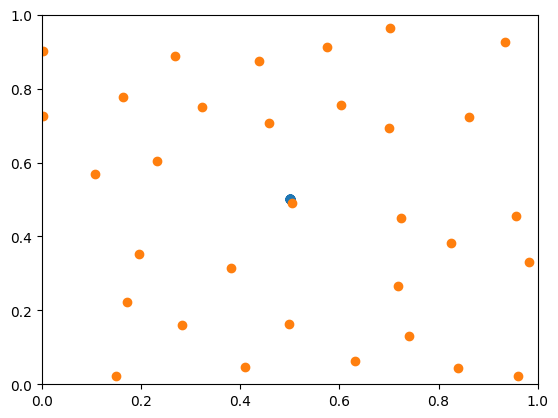

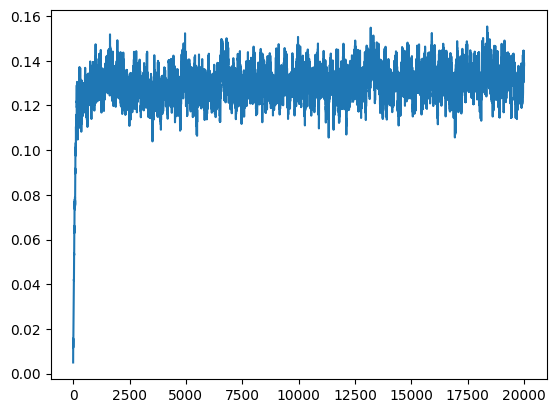

In [82]:
A = np.random.randn(32, 2)*0+0.5

plt.scatter(*A.T); plt.xlim(0, 1); plt.ylim(0, 1)
fitness = []
# plt.show()
for i in tqdm(range(20000)):
    idx = np.random.randint(0, len(A))
    a = A[idx]
    a = a + 1e-1*np.random.randn(2)
    
    B = np.concatenate([A, a[None]])
    D = np.linalg.norm(B[:, None, :] - B[None, :, :], axis=-1)
    D[np.arange(33), np.arange(33)] = np.inf
    i2 = D.min(axis=-1).argmin()
    if i2<len(A):
        A[i2] = a
    A = A%1
    fitness.append(D.min(axis=-1).mean())
    
plt.scatter(*A.T); plt.xlim(0, 1); plt.ylim(0, 1)
plt.show()
plt.plot(fitness)
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

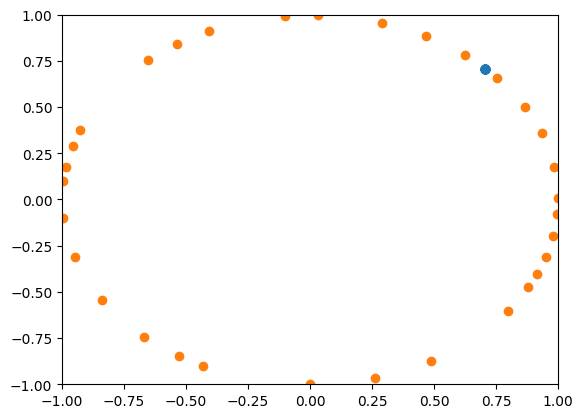

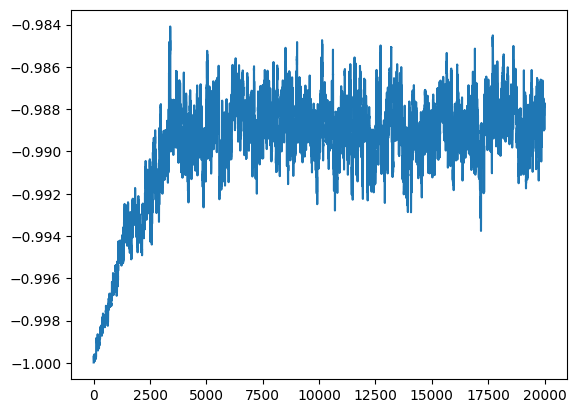

In [100]:
A = np.random.randn(32, 2)*0+0.5
A = A/np.linalg.norm(A, axis=-1, keepdims=True)

plt.scatter(*A.T); plt.xlim(-1, 1); plt.ylim(-1, 1)
fitness = []
# plt.show()
for i in tqdm(range(20000)):
    idx = np.random.randint(0, len(A))
    a = A[idx]
    a = a + 1e-1*np.random.randn(2)
    a = a/np.linalg.norm(a, axis=-1)
    
    B = np.concatenate([A, a[None]])

    D = -B@B.T
    
    D[np.arange(len(A)+1), np.arange(len(A)+1)] = np.inf
    i2 = D.min(axis=-1).argmin()
    if i2<len(A):
        A[i2] = a
    A = A/np.linalg.norm(A, axis=-1, keepdims=True)
    fitness.append(D.min(axis=-1).mean())
    
plt.scatter(*A.T); plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.show()
plt.plot(fitness)
plt.show()

In [98]:
np.arccos(-fitness[-1])/np.pi*180

31.009555716523078

In [99]:
np.arccos(-fitness[-1])/2/np.pi

0.08613765476811966

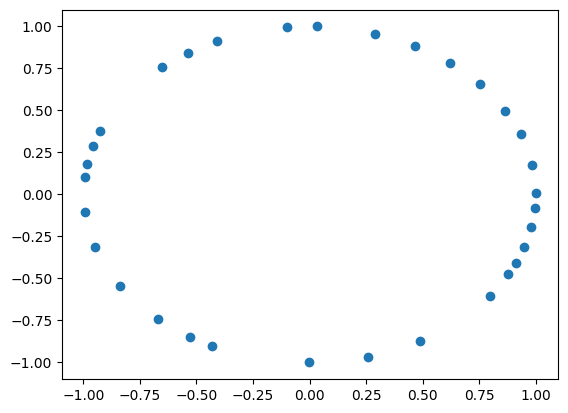

In [103]:
plt.scatter(*A.T)

In [112]:
(np.arccos(-D.min(axis=-1))/np.pi*180).mean()

8.156077444402873